# Cloud Topic Modeling
A QuantumFinance tem um canal de atendimento via chat e precisar classificar os assuntos dos atendimentos para melhorar as tratativas dos chamados dos clientes. O canal recebe textos abertos dos clientes relatando o problema e/ou dúvida e depois é direcionado para algum uma área especialista no assunto para uma melhor tratativa.​  

Crie um modelo classificador de assuntos aplicando técnicas de PLN, que consiga classificar através de um texto o assunto conforme disponível na base de dados para treinamento e validação do modelo seu modelo.​  

O modelo precisar atingir um score na métrica F1 Score superior a 75%. 
Utilize o dataset para treinar e testar o modelo, separe o dataset em duas amostras (75% para treinamento e 25% para teste).

Utilize somente plataformas de machine learning baseado em cloud para desenvolver a solução.

## 1. Import Libs

In [39]:
import boto3
import requests
from dotenv import load_dotenv
import os
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from io import StringIO
import warnings
warnings.filterwarnings("ignore")
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# import nltk
# import spacy
# # Carregar o modelo do spaCy
# nlp = spacy.load('pt_core_news_sm')
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# nltk.download('stopwords')
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cintia.duarte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Export Data

In [3]:

url = "https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv"

local_filename = "../src/data/01_raw/tickets_reclamacoes_classificados.csv"

import os
if not os.path.exists(os.path.dirname(local_filename)):
    os.makedirs(os.path.dirname(local_filename))

response = requests.get(url)

with open(local_filename, 'wb') as file:
    file.write(response.content)

print(f"Arquivo salvo com sucesso em: {local_filename}")


Arquivo salvo com sucesso em: ../src/data/01_raw/tickets_reclamacoes_classificados.csv


## 3. Train and Test data

In [4]:
# Arquivo salvo localmente para desenvolvimento do modelo
df = pd.read_csv("../src/data/01_raw/tickets_reclamacoes_classificados.csv", sep=";")

In [9]:
# divisão da amostra entre treino e teste
df_train, df_test = train_test_split(
      df,
      test_size = 0.25,
      random_state = 42
  )

In [11]:
df_train.shape, df_test.shape

((15804, 4), (5268, 4))

## 4. Cleaning data and load to S3

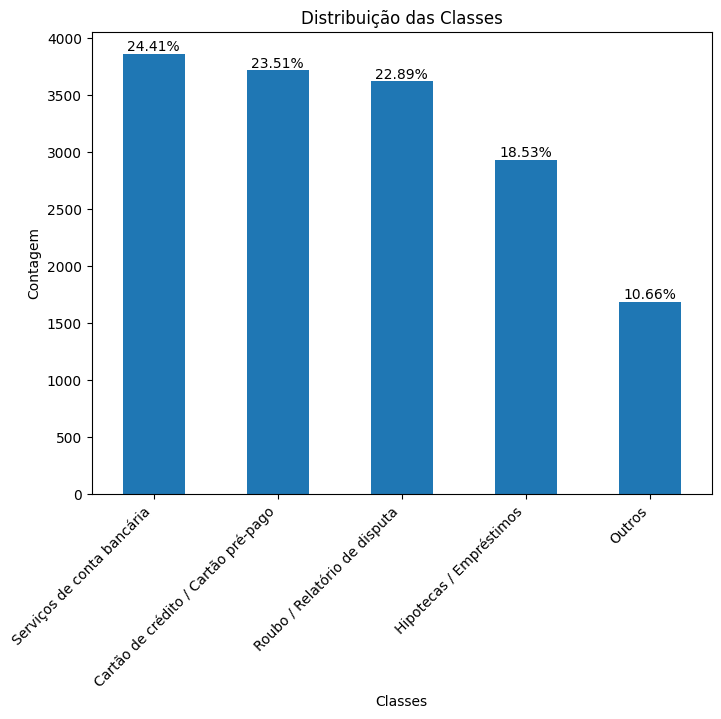

In [15]:
## VISUALIZACAO DO BALANCEMANETO DE CLASSES NA BASE DE TREINO

contagem_classes = df_train['categoria'].value_counts()
total_ocorrencias = contagem_classes.sum()
percentuais = (contagem_classes / total_ocorrencias) * 100

plt.figure(figsize=(8, 6))
grafico = contagem_classes.plot(kind='bar')
plt.title('Distribuição das Classes')
plt.xlabel('Classes')
plt.ylabel('Contagem')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha='right')

for i in range(len(contagem_classes)):
    plt.text(i, contagem_classes[i], f'{percentuais[i]:.2f}%', ha='center', va='bottom')

plt.show()

In [19]:
df_train.head()

id_reclamacao              data_abertura  \
15809        2598821  2017-08-08T12:00:00-05:00   
2087         3755023  2020-07-20T12:00:00-05:00   
15551        2323849  2017-02-02T12:00:00-05:00   
15204        1348535  2015-04-27T12:00:00-05:00   
11228        2601039  2017-08-10T12:00:00-05:00   

                                 categoria  \
15809           Serviços de conta bancária   
2087            Serviços de conta bancária   
15551  Cartão de crédito / Cartão pré-pago   
15204              Hipotecas / Empréstimos   
11228              Hipotecas / Empréstimos   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [22]:
def limpar_padroes(texto):
    """
    Função criada com o objetivo de retirar padrões que não são úteis para a classificação
    """
    padroes = [
        'XXXX', 'XXX', 'xxxx', 'Xxxx',
        r'\r', r'\n',
        r'\d{1,2}/\d{1,2}/\d{4}',  # Data xx/xx/xxxx
        r'\d{2}/\d{2}/\d{4}',  # Data xx/xx/xxxx (sem espaço)
        r'\d{1,2}/\d{1,2}/\d{4}/\d{2}/\d{2}',  # Data xx/xx/xxxx/xx/xx
        r'/Xxxx', '\(', '\)', "'", '"',
        r'\{\$[\d\.,]+\}',
        r'XX/XX/',  # Padrão XX/XX/
        r'xx/xx/',  # Padrão xx/xx/
        r'//',  # Padrão //
        r'/xx/xx '  # Padrão /xx/xx com espaço
    ]

    for padrao in padroes:
        texto = re.sub(padrao, '', texto, flags=re.IGNORECASE)

    # Substituir "{$ qualquer_valor}" por "R$ qualquer_valor"
    texto = re.sub(r'\{\$ *([\d\.,]+)\}', lambda match: '$ ' + match.group(1), texto)

    return texto

def remove_punctuation(text):
    """
    Função que remove pontuação
    """
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)
    return text


def remover_stopwords(texto, metodo='ambos'):
    """
    Função para remover stopwords de um texto.

    Parâmetros:
        texto (str): O texto a ser processado.
        metodo (str): Método de remoção de stopwords a ser utilizado. Pode ser 'spacy', 'nltk' ou 'ambos'.

    Retorna:
        str: O texto sem as stopwords.
    """

    nltk.download('stopwords')
    nlp = spacy.load('pt_core_news_sm')

    if metodo == 'spacy':
        nlp = spacy.load('pt_core_news_sm')
        stops = nlp.Defaults.stop_words
    elif metodo == 'nltk':
        stops = nltk.corpus.stopwords.words('portuguese')
    elif metodo == 'ambos':
        stops = list(set(nlp.Defaults.stop_words).union(set(nltk.corpus.stopwords.words('portuguese'))))
    else:
        raise ValueError("Método de remoção de stopwords inválido. Use 'spacy', 'nltk' ou 'ambos'.")

    return stops

In [26]:
## Normalização dos dados de treino
df_train['descricao_reclamacao_normalized'] = df_train['descricao_reclamacao'].apply(limpar_padroes)
df_train['descricao_reclamacao_normalized'] = df_train['descricao_reclamacao_normalized'].apply(remove_punctuation)
df_train = df_train[['categoria', 'descricao_reclamacao_normalized']].reset_index(drop=True)
df_train.to_csv("../src/data/02_silver/dados_tratados.csv", index=False)

In [42]:
## Normalização dos dados de teste
df_test['descricao_reclamacao_normalized'] = df_test['descricao_reclamacao'].apply(limpar_padroes)
df_test['descricao_reclamacao_normalized'] = df_test['descricao_reclamacao_normalized'].apply(remove_punctuation)
df_test = df_test[['categoria', 'descricao_reclamacao_normalized']].reset_index(drop=True)
df_test.to_csv("../src/data/02_silver/dados_tratados_teste.csv", index=False)

df_test_s_categoria = df_test[['descricao_reclamacao_normalized']].reset_index(drop=True)
df_test_s_categoria.to_csv("../src/data/02_silver/dados_tratados_teste_scategoria.csv", index=False)

In [55]:
## Carregar os arquivos normalizados para o s3
load_dotenv()

ACCESS_ID = os.getenv("ACCESS_ID")
ACCESS_KEY = os.getenv("ACCESS_KEY")
region = os.getenv("region")

session = boto3.Session(
    aws_access_key_id=ACCESS_ID,
    aws_secret_access_key=ACCESS_KEY,
    region_name=region
)

# Nome do bucket
bucket_name = 'nlp-topic-modeling'

# Recurso S3 da sessão
s3_resource = session.resource('s3')

# SALVAR OS DADOS DE TREINO NO S3
object_name_train = 'silver-data/train-data/df_train.csv'
csv_buffer_train = StringIO()
df_train.to_csv(csv_buffer_train, index=False)
s3_resource.Object(bucket_name, object_name_train).put(Body=csv_buffer_train.getvalue())

# SALVAR OS DADOS DE TESTE NO S3
object_name_test = 'silver-data/test-data/df_test.csv'
csv_buffer_test = StringIO()
df_test.to_csv(csv_buffer_test, index=False) 
s3_resource.Object(bucket_name, object_name_test).put(Body=csv_buffer_test.getvalue())



{'ResponseMetadata': {'RequestId': 'Q2CDTM0TRRKR0QW0',
  'HostId': 'gtvKERqZiHHRlgZqJv0zYZz3x9fdw3PXVD4AXTGdypFgJeDFtcgkOhbg1Wxxq0fz4L9f06jf/8eTYsQlAyhH9A==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'gtvKERqZiHHRlgZqJv0zYZz3x9fdw3PXVD4AXTGdypFgJeDFtcgkOhbg1Wxxq0fz4L9f06jf/8eTYsQlAyhH9A==',
   'x-amz-request-id': 'Q2CDTM0TRRKR0QW0',
   'date': 'Sun, 31 Mar 2024 21:24:08 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"af79f3c03e99ffe6500ef9d41c90a870"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"af79f3c03e99ffe6500ef9d41c90a870"',
 'ServerSideEncryption': 'AES256'}

In [56]:
df_train.head(2)

categoria  \
0  Serviços de conta bancária   
1  Serviços de conta bancária   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## 5. Training Data

In [57]:


# Inicializar o cliente do Amazon Comprehend
comprehend = session.client('comprehend', region_name=region)

# Especificar os caminhos S3 para os dados de treino e teste, e o output
s3_train_data = 's3://nlp-topic-modeling/silver-data/train-data/df_train.csv'
s3_test_data = 's3://nlp-topic-modeling/silver-data/test-data/df_test.csv'
s3_output = 's3://nlp-topic-modeling/model-output/'

# Usar o ARN da Role criada
data_access_role_arn = 'arn:aws:iam::471112739099:role/ComprehendS3AccessRole'

# Criar o classificador de documentos
response = comprehend.create_document_classifier(
    DocumentClassifierName='ClassificadorAtendimento',
    VersionName='v1',
    DataAccessRoleArn=data_access_role_arn,
    InputDataConfig={
        'S3Uri': s3_train_data,
        'TestS3Uri': s3_test_data
    },
    OutputDataConfig={
        'S3Uri': s3_output
    },
    LanguageCode='pt'
)

print(response)


{'DocumentClassifierArn': 'arn:aws:comprehend:us-east-1:471112739099:document-classifier/ClassificadorAtendimento/version/v1', 'ResponseMetadata': {'RequestId': '89d28a1a-8e8b-4a08-b784-e783b663d6bf', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '89d28a1a-8e8b-4a08-b784-e783b663d6bf', 'content-type': 'application/x-amz-json-1.1', 'content-length': '125', 'date': 'Sun, 31 Mar 2024 21:25:42 GMT'}, 'RetryAttempts': 0}}


In [77]:
status_response = comprehend.describe_document_classifier(
    DocumentClassifierArn='arn:aws:comprehend:us-east-1:471112739099:document-classifier/ClassificadorAtendimento/version/v1'
)
print(status_response['DocumentClassifierProperties']['Status'])


TRAINING


## 6. Results 

In [59]:


# Inicializar o cliente do Amazon Comprehend
comprehend = session.client('comprehend', region_name=region)

# Substitua 'document-classifier-arn' pelo ARN do seu classificador de documentos
document_classifier_arn = 'arn:aws:comprehend:us-east-1:471112739099:document-classifier/ClassificadorAtendimento/version/v1'

# Obter as propriedades do classificador de documentos
response = comprehend.describe_document_classifier(
    DocumentClassifierArn=document_classifier_arn
)

# Imprimir as métricas de avaliação
print(response['DocumentClassifierProperties']['ClassifierMetadata']['EvaluationMetrics'])


KeyError: 'ClassifierMetadata'